#### _Speech Processing Labs: Signals 2: The Source Filter Model_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft

import cmath
from math import floor
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, Audio
plt.style.use('ggplot')


In [2]:
#!pip install librosa
import librosa

# The Source Filter Model

### Learning Outcomes

* Explain why an impulse train is used to model the voice source
* Describe the frequency response of an impulse train and a filtered impulse train
* Understand how IIR filters can be applied to impulse trains and other representations of the vocal source to produce different spectral envelopes
* Understand how we can use the computational approximation of the source filter model to generate simple speech sounds. 

### Need to know
* Speech Zone Module 4 videos
* Reading: R. Waytree (2019) Phonetics: a practical perspective, Chapters 6 and 7

<div class="alert alert-warning">
<strong>Equation alert</strong>: If you're viewing this on github, please note that the equation rendering is not always perfect. You should view the notebooks through a jupyter notebook server for an accurate view.
</div>


### Overview

In this notebook we'll:
* Generate and inspect some impulse trains to observe their audio and spectral properties.
* Look at how Finite Impulse Response (FIR) and Infinite Impulse Response (IIR) filters can be used shape the spectral properties of the sounds they are applied to.
* See specifically what a pre-emphasis filter does and why this is classified as an FIR filter.
* Use Linear Predictive Coding to derive IIR filters directly from speech and then use the learned filter to synthesize some vowel(-ish) sounds. 


You should go through the notebook and work through the tasks and questions with the given code. 

# Impulse Trains


In this modules videos, you saw that we can approximate the vocal source with an impulse train. 

Let's see and hear what an impulse train is. To do this, we have a function that makes am 
an impulse train of `n_samples`, given a specific `frequency` and `sample_rate`:


In [3]:
def get_impulse_train(sample_rate, frequency, n_samples):    
    # make an arrange of n_samples, all zeros to start
    x = np.zeros(n_samples)
    
    # Determine where the impulses go based on the sample rate
    # The time between samples: sample_time = 1/sample_rate
    
    #A frequency of f cycles/second means the wavelength=1/f
    # So samples_per_cycle = wavelength/t_s = 1/frequency / 1/sample_rate = sample_rate/frequency
    
    ## We need to round to the nearest integer
    samples_per_cycle = round(sample_rate/frequency)
    
    # Set indices for impulses
    impulse_positions = np.arange(0, n_samples, samples_per_cycle)
 
    # uncomment the following line if you what to print out what the impulse positions are
    print("impulse_positions:", impulse_positions)
    
    # set the impulses
    x[impulse_positions] = 1
    
    ## return the time steps associated with the impulse train samples
    nsteps = np.array(range(n_samples))
    time_steps = (1/sample_rate) * nsteps   
    
    return x, time_steps

Now, let's use this function to make an impulse train of 1 second with a sampling rate of 8000 Hz and impulse frequency of 100 Hz.

impulse_positions: [   0   40   80  120  160  200  240  280  320  360  400  440  480  520
  560  600  640  680  720  760  800  840  880  920  960 1000 1040 1080
 1120 1160 1200 1240 1280 1320 1360 1400 1440 1480 1520 1560 1600 1640
 1680 1720 1760 1800 1840 1880 1920 1960 2000 2040 2080 2120 2160 2200
 2240 2280 2320 2360 2400 2440 2480 2520 2560 2600 2640 2680 2720 2760
 2800 2840 2880 2920 2960 3000 3040 3080 3120 3160 3200 3240 3280 3320
 3360 3400 3440 3480 3520 3560 3600 3640 3680 3720 3760 3800 3840 3880
 3920 3960 4000 4040 4080 4120 4160 4200 4240 4280 4320 4360 4400 4440
 4480 4520 4560 4600 4640 4680 4720 4760 4800 4840 4880 4920 4960 5000
 5040 5080 5120 5160 5200 5240 5280 5320 5360 5400 5440 5480 5520 5560
 5600 5640 5680 5720 5760 5800 5840 5880 5920 5960 6000 6040 6080 6120
 6160 6200 6240 6280 6320 6360 6400 6440 6480 6520 6560 6600 6640 6680
 6720 6760 6800 6840 6880 6920 6960 7000 7040 7080 7120 7160 7200 7240
 7280 7320 7360 7400 7440 7480 7520 7560 7600 7640 7680 77

[(-1.0, 2.0), (0.0, 0.1)]

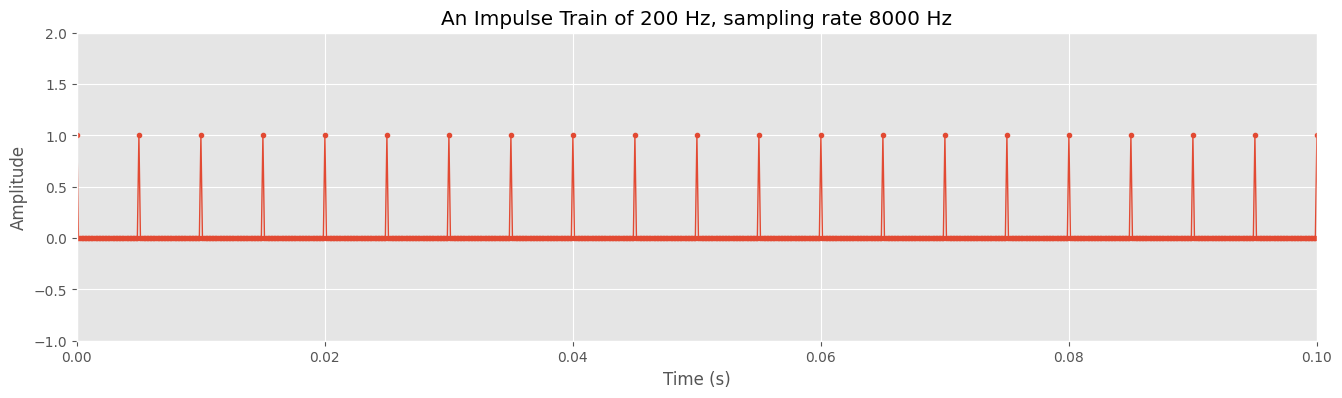

In [4]:
## set f_s be the sampling frequency (8000 Hz)
f_s = 8000

## set N as the number of samples we'd need given f_s so to make in impulse train on 1 s 
N = f_s

## Set frequency as the desired impulse frequency (100 Hz)
## Change this value to change the F0 of the impulse train
frequency = 200

## Generate N samples of an impulse train with frequency=frequency given a sampling rate of f_s
x_imp, time_steps = get_impulse_train(sample_rate=f_s, frequency=frequency, n_samples=N)

## Set up the plot
fig, ax = plt.subplots(figsize=(16, 4))
ax.set(xlabel="Time (s)", ylabel="Amplitude", title=f"An Impulse Train of {frequency} Hz, sampling rate {f_s} Hz")

## Plot the samples
ax.plot(time_steps, x_imp, linewidth=1, marker=".")

## Set the y and x axis limits to zoom in
ax.set(ylim=[-1,2], xlim=[0,0.1])


**WARNING: check your volume before you play this over headphones! It might be very loud**

In [5]:
## Make an audio widget to play our impulse train
Audio(x_imp, rate=f_s)

**Task:** Change the `frequency` variable above to try out some different frequencies for the impulse train and verify that:
* The percieved pitch changes
* If the time between impulses get's long enough, you'll hear individual pulses

**Question:** What sort of speech sounds can an impulse train potentially be a source for? 

An impulse train can be used as a source for vowels. In general it can be used for voiced sounds (but some voiced sounds such as fricative consonants will also require turbulent airflow).

## Spectrograms for impulse trains

To see why impulse trains are a useful approximation of the vocal source, let's plot spectrogram for the impulse train of 100 Hz with 8000 Hz sample rate (create this using the code above). Set the size of the DFT input window to $N=80$ samples. 

**Question:** Before you plot the spectrogram, think about what you expect to see? Which frequency components should be present in the signal for a DFT input window of $N$ = 800, and input impulse train of 100 Hz, and a sampling rate of $f_s$ = 8000 Hz? 
* What are the analysis frequencies for this DFT setup?
* What is the fundamental frequency (F0) and harmonics for this impulse train


**Answer**
* The analysis frequencies for will be multiples of $f_s/N = 8000/80 = 100$ Hz up to the Nyquist frequency 
$f_s/2 = 8000/2 = 4000 Hz$.  That is multiples of 100 Hz up to 4000 Hz

* The F0 of the impulse train will be 100 Hz, and so it's harmonics will be multiples of 100 Hz.

So, we expect every analysis frequency to have a non-zero magnitude.  Now let's try plotting it! 

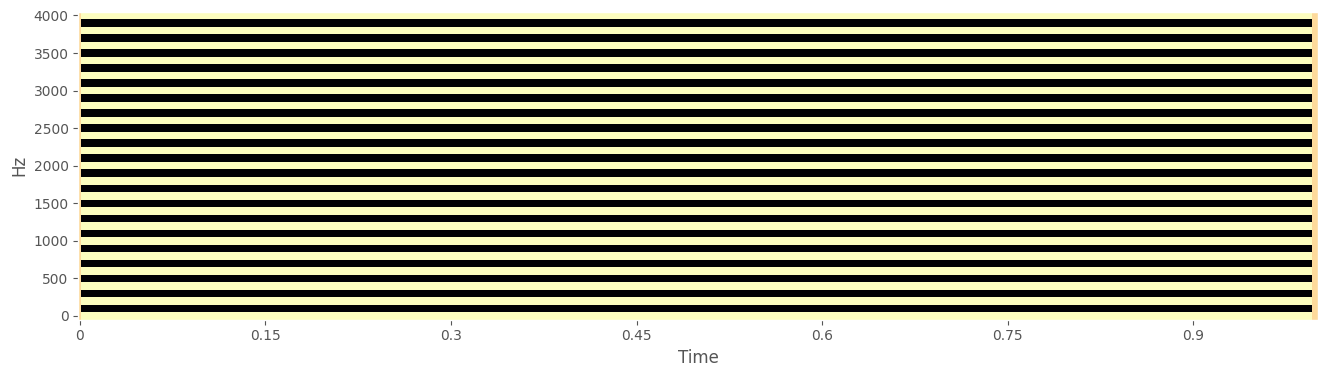

In [6]:
## Let N be the number of samples in the DFT input window
N=80

## Use the librosa stft function to get the get apply the DFT across the impulse train
## Set the window type to "boxcar" i.e., rectangular
X_stft = librosa.stft(x_imp, n_fft=N, window="boxcar")

## Use get the absolute values of the stft output to convert to the magnitude spectrum
mags = np.abs(X_stft)

## Set up the 2 subsplots: one for the spectrogram
fig, ax = plt.subplots(figsize=(16,4))

## Plot the spectrogram using librosa specshow
librosa.display.specshow(librosa.amplitude_to_db(mags, ref=np.max), sr=f_s, n_fft=N, hop_length=N//4,
                         y_axis='linear', x_axis='time', ax=ax)

#ax.set(ylim=[0,500], xlim=[0,1])




You should see a completely "full" spectrogram - every frequency 'bin' in this heatmap is highlighted as it has a positive magnitude. 

This is because, in this case, the impulse train harmonics exactly match the DFT analysis frequencies! 

**Task:** Try changing the impulse train to 200 Hz.  What happens to the spectrogram? How about 500 Hz?  What's happens to the harmonics as you increase F0? What if you change the impulse train's F0 to something between the DFT analysis frequencies, like 450 Hz?



**Answer**: At 200 Hz we get bright bands at multiples of 200, with gaps between. Similar with 500 Hz impulse train.
At 250 Hz and 450 Hz (not multiple of analysis frequency) we get bands at multiples divisible, but they are no longer at constant values, and there is leakage at other values.

### Spectral slices for impulse trains
Now, let's verify what the spectrum for an individual frame (i.e. DFT input window) of this impulse train looks like. 
We can do this by plotting the magnitude spectrum for a specific frame.  Here we (pseudo-)randomly pack the 50th frame. 

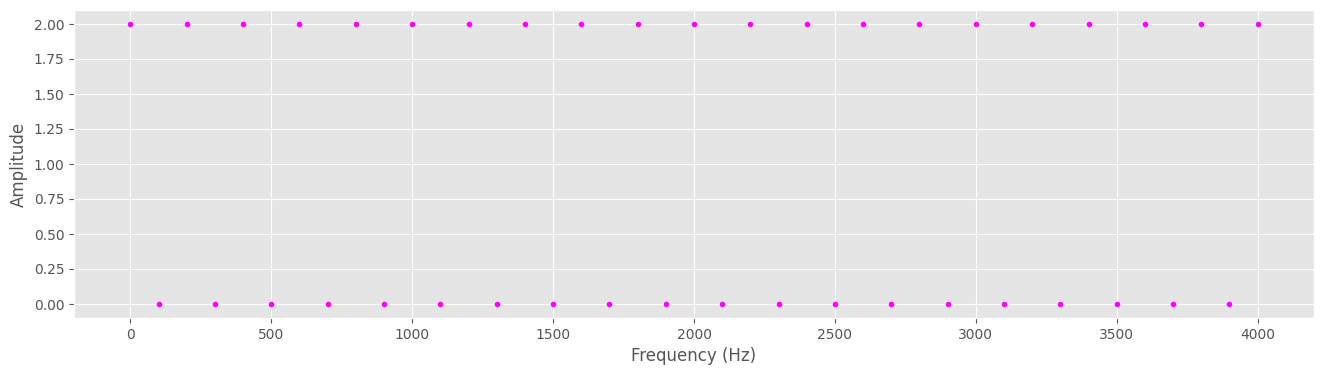

In [7]:
## First calculate the analysis frequencies, up to the Nyquist frequency
analysis_freqs = np.arange(0,N//2 + 1) * (f_s/N)

## plot the magnitudes from the 50th column of the mag spectrogram output
fig, ax = plt.subplots(figsize=(16,4))
ax.set(xlabel="Frequency (Hz)", ylabel="Amplitude")
ax.plot(analysis_freqs, mags[:,50], linewidth=0, color='magenta', marker=".", label='magnitude')


* For an impulse train of 100 Hz, you should see that all the analysis frequencies have magnitude 1, i.e. multiples of 100 Hz
* For an impulse train of 500 Hz, every 5th analysis frequency has a positive magnitude, i.e. multiples of 500 Hz

**Question:** How would you describe the spectral envelope of these impulse trains? Why is this potentially a good thing for modelling voiced speech sounds?

**Answer**: The spectral envelope would be just a constant flat line. That means that all frequencies (not counting harmonic structure) are included. This is good for modelling speech sounds as it means that we can multiply that spectral envelope by any filter we need to achieve the desired sound.

# Filters

Above we created an impulse train that we can use to approximate a voiced vocal source. Now let's look at some filters. 
Our eventual goal is to use filters to model the effect of the vocal tract on the source.  

We apply filters to waveforms to change to change their spectral characteristics.  In the videos, you were introduced to two general filter types: Finite Impulse Response (FIR) and Infinite Impulse Response (IIR) filters.  

Similar to how we make spectrograms, FIR and IIR filters produce output waveforms by applying a formula over windows of the input waveform stepped through time.  The crucial difference between these two types of filters is that IIR filters include previous outputs of the filter as well as the input waveform in creating the output.  This means that, theoretically, they can produce a never-ending output! That specific ability is not very useful to us, but other properties of IIR filters are very useful for speech processing. 

First, however, let's look at a common use of FIR filters. 

# FIR Filters and Pre-emphasis

## Definition of an FIR filter

Finite Impulse Response (FIR) filters have the following form: 

$$
\begin{align}
y[n] &= b[0]x[n] + b[1]x[n-1] + \dots + b[K]x[n-K] \\
 &= \sum_{k=0}^K b[k] x[n-k]
\end{align}
$$

Here, we have: 
* an input sequence $x[n]$ of length $N$
    * e.g. a sampled sound wave, like an impulse train 
* a set of $K$ filter coefficients.
    * $K$ number that we use to weight the previous samples of the input when producing the filtered output at that point in time.  

We can read the equation as saying that $n$-th ouput of the filter, $y[n]$, is a weighted sum of the previous K inputs $x[n],...,x[n-K]$.  

 


## Example: The Pre-emphasis filter

A very common use of FIR filters is to create low-pass filters.  That is, filters that remove frequencies above a certain threshold. This is very useful for removing high frequency noise from a signal (e.g., for analysis longer term F0 contours).  However, in speech processing probably the most frequently used filters is the pre-emphasis filter. This is a commonly done in the automatic speech recognition pipeline before extracting spectral features from input recordings. 

Pre-emphasis filters have the following form: 

$$y[n] = x[n] - p x[n-1]$$

where $p$ is usually between $0.9$ and $0.98$.   

We'll come back to why this is used in the ASR pipeline later in the course.  For now, let's just have look at what it does to an input.  First, here's a function, `fir_filter` that takes a waveform `x` as input and applies the FIR filter specified by the list of coefficients `b`.  

_If you have some python coding experience and want some practice, try coding this up yourself based on the definition above_


In [8]:
## A general fir filter applying an FIR filter, defined by filter_coefficients, to input x 
def fir_filter(x, b):
    # Set N and K to match the definition above
    # N is the length of the input waveform, K is the number of FIR coefficients
    N = len(x)  

    # K is the number of filter coefficients 
    K = len(b)

    # Initialize the output array to be the same size as the input but with all 
    # values set to zero
    y = np.zeros(N)   

    # Step through the input from samples 0 to N
    for n in range(N): 

        # Calculate the current output as a weighted sum of previous inputs,
        # multiplying the n-kth input sample with the kth filter coefficient
        for k in range(K):
            if n-k >= 0: 
                y[n] = y[n] + (b[k]*x[n-k])
    return y    

### Apply the filter to a speech sample

Let's try applying the pre-emphasis filter to Rebekka's recording from the module 1 lab. You can always substitute your own recording in your want to try that out instead! 

First, we'll load the recording using the librosa load function and check that it sounds like we expect. 

In [9]:
## Load a sound file using librosa.load
## we store the waveform amplitudes in variable x and the sampling rate in sr
x, sr = librosa.load('../../phon/phon_lab_1/audio/speechproc_phonlab1_1.wav')

print("audio: Rebekka saying 'Take a picture. It'll last longer'")

## make and audio widget to play the recording in python
## Question (module 3): what happens if you don't put in the right sample rate? 
Audio(x, rate=sr)

audio: Rebekka saying 'Take a picture. It'll last longer'


Now we'll apply the pre-emphasis filter. We use the function we defined earlier to do this, and set the $b$ coefficients in the list `pre_emph_coeffs`.

In [10]:
## Set the filter coefficients.  The first one corresponds to x[n], the second to x[n-1]
pre_emph_coeffs = [1.0]*10

## Apply the filter to x 
y = fir_filter(x, b=pre_emph_coeffs)

## Listen to the output
print("audio with pre-emphasis filter")
Audio(y, rate=sr)

audio with pre-emphasis filter


**Question:** What has changed in the sound of the recording comparing the unfiltered and filtered versions?  Can you describe it in terms of frequencies in the audio? 

**Answer**: It seems to sounds a bit quieter and flatter, with fewer frequencies present, particularly lower ones.

### Spectral characteristics of the pre-emphasis filter
We can see more clearly what the filter did by looking at the spectrograms of the two waveforms, so let's plot them now.  

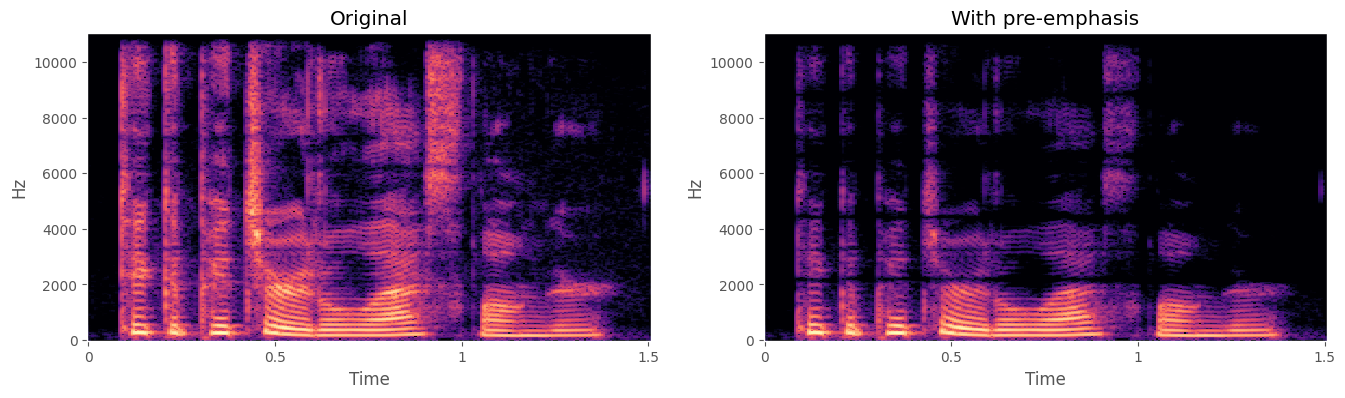

In [11]:
## Set the DFT input length to N=512
N=512

## Get the magnitude spectrums for both recordings
mags1 = np.abs(librosa.stft(x, n_fft=N))
mags2 = np.abs(librosa.stft(y, n_fft=N))

## Set up a side by side plot
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

## Plot the spectrogram of the original recording in ax1 (left)
ax1.set(title="Original")
librosa.display.specshow(librosa.amplitude_to_db(mags1, ref=np.max), sr=sr, n_fft=N, hop_length=N//4,
                         y_axis='linear', x_axis='time', ax=ax1)

## Plot the spectrogram of the filtered recording in ax2 (right)
ax2.set(title="With pre-emphasis")
librosa.display.specshow(librosa.amplitude_to_db(mags2, ref=np.max),sr=sr, n_fft=N, hop_length=N//4,
                         y_axis='linear', x_axis='time', ax=ax2)

**Question:** What effect did the filter have on the spectral characteristics of the recording? 



**Answer**: It seems to have emphasised the higher frequencies (maybe added some noise) and decreased the lower frequencies, making it easier to analyse higher formants.

## Frequency Response of an FIR filter

A very neat thing about FIR filters is that you can find out what effect they will have on different frequencies simply by 
applying the DFT to the filter coefficients themselves. 

To do this we create a window of size $N$ (The same as our desired DFT input window), put the filter coefficients at the beginning of the window, and set the rest of the window to zero.  So, a window representing the pre-emphasis filer looks like `[1, -0.98, 0,...,0]`.  

If we then apply the DFT to this window and look at the magnitude spectrum, we'll see which frequencies get dampened and which get boosted by the filter, i.e., the **frequency response** of the filter

Let's try it out with our pre-emphasis coefficients, for an input window of size $N=512$ and a sampling rate $f_s$ equal to our recording (22050 Hz), which was stored in the variable `sr` when we loaded the audio. 


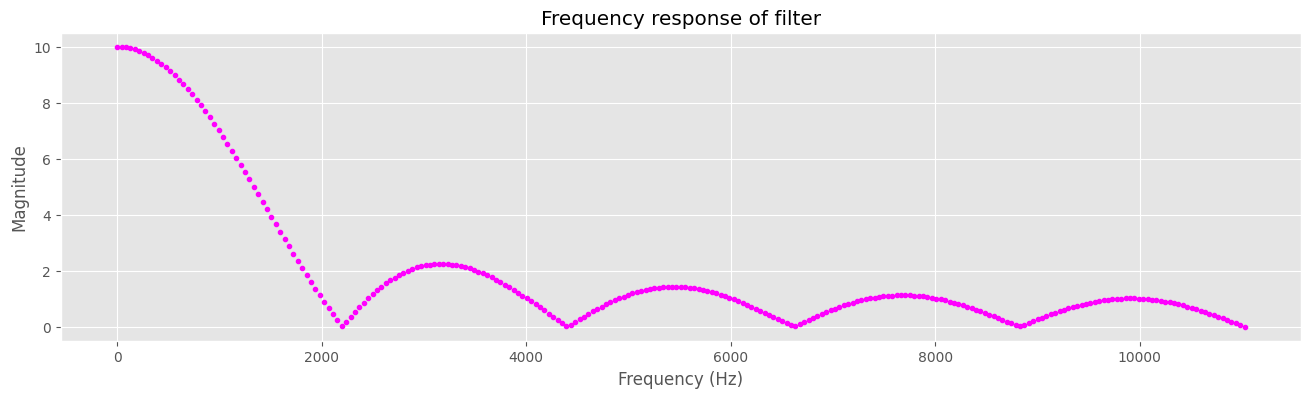

In [12]:
N=512 ## input window size

## make an array size N, initialised to all zeros
filter_window = np.zeros(N)

## Set the first element of the window to coefficient 1 (corresponding to x[n])
filter_window[0] = 1

## Set the 2nd element of the window to coefficient -0.9 (corresponding to x[n-1])
filter_window[1] = 0.98

filter_window[0:10] = 1

## Apply the fft and take the absolute value to get the magnitude spectrum of the window
fmags = np.abs(np.fft.fft(filter_window))


## set the sampling rate
f_s = sr 

## Calculate the analysis frequencies up to the Nyquist frequency
analysis_freqs = np.arange(0,N//2 + 1) * (f_s/N)

## Plot the magnitude spectrum
fig, ax = plt.subplots(figsize=(16,4))
ax.set(xlabel='Frequency (Hz)', ylabel='Magnitude', title="Frequency response of filter")
ax.plot(analysis_freqs, fmags[0:N//2 + 1], linewidth=0, color='magenta', marker=".", label='magnitude')


You should see that a slightly curved line that rises from 0 to the Nyquist frequency.  That is, our pre-emphasis filter 
boosts higher frequencies. The frequency response here tells us that this is a high pass filter with a fairly shallow drop off, so it we see more high frequency information but don't lose everything in the lower frequencies. 

Being able to determine the frequency response directly from the filter coefficients is very convenient.  That means that we don't have to apply it to a wave step by step in the time domain to know what it does.  In fact, we can determine what a filter will do to a specific waveform by looking at their spectrums in the frequency domain.  We'll see this later in the course as the **convolution theorem**.

**Task:** 

* Change the second filter coefficient from -0.98 to +0.98 (i.e. `filter_window[1] = 0.98`).
    * What happens to the frequency response of the filter?
    * What happens if you change the coefficients to `pre_emph_coeffs = [1.0, 0.98]` when applying the filter to the recording?  Does it match the predicted frequency response?   


* Try changing `pre_emph_coeffs = [1.0] * 10` above (this is shorthand for getting a list of ten 1's).
    *  What happens to the spectrogram when you apply this new filter to the recording?
    *  Is this matched by the frequency response of the filter? i.e., change set `filter_window[0:10] = 1.0` above.
 

**Answer**:
* Filter changed.
    * It gets flipped around half the nyquist frequency, so it now becomes a light low-pass filter, that doesn't lose all higher frequency.
    * Yes the recording does sounds a bit lower, but the effect is not as pronounced.
* Coeffs changed.
    * It seems flatter with less variation in frequency.
    * Yes, it's a mean of the few previous sounds and it removes noise, but also higher frequencies. 

# IIR Filters 

We've just seen that we can use FIR filters to shape the spectral characteristics of speech recordings.  We can also use FIR filters to shape the spectral envelope of an impulse train.  This potentially gives us a way to model the vocal tract.  However, it turns out that FIR filters aren't really powerful enough to model the types of vocal tract resonances that we need to generate speech sounds.  

Instead, we'll look at Infinite Impulse Response (**IIR**) filters, which allow us to model more complex feedback behaviour that's closer to what we might expect from the vocal tract.

## Definition of an Infinite Impulse Response filter

Unlike FIR filters, IIR filters use outputs from previous time steps to calculate the next output. 

$$ y[n] = \sum_{k=0}^N b[k] x[n-k] + \sum_{k=0}^M a[k] y[n-k]$$

The 'infinite' in the name comes from the fact that you can define a filter in this way so that a single impulse results in an infinitely long non-zero output sequence.  



These can be much more efficient than using an FIR filter: we can get the same effect with fewer parameters. (e.g. in some cases you can define a 4th order IIR filter that does the same job as a 19th order FIR filter). The flip side is that they're harder to analyze. 

Unfortunately, there's no direct way to compute the a[k]'s and b[k]'s from the impulse response for an IIR filter, but we can use the **z Transform** to do this (we won't go into it in this class).  Instead we'll focus on how we can use an IIR filter to create a speech shaped sound.  



**Question:**  Consider the following filter:

$$ y[n] =  x[n] + y[n-1] $$  

With an input of a single impulse, i.e., if $x[n] = 1$ for $n=1$ and 0 otherwise.  Calculate the following outputs: 

* $ y[1] = ...$
* $ y[2] = ...$ 
* $ y[3] = ...$

Does this waveform created by this filter ever fade away to zero amplitude?


Answer

y[1] = x[1] + y[0] = 1 + 0 = 1
y[2] = x[2] + y[1] = 0 + 1 = 1
y[3] = x[3] + y[2] = 0 + 1 = 1

The waverform remains constant, and never fades away.

### An IIR function
Now, let's define a function to calculate the output of an IIR filter given feedback coefficients `a` and feedforward coefficients `b`.

_Alternative: write the function yourself!_

In [13]:
# iir_filter applies the IIR filter defined by feedforward coefficients, b, and feedback coefficients, a,
# where the coefficients are input as ordered lists
# Note: this isn't very pythonic (even less than usual), but it allows us to write things out 
# closer to the equations above - just don't take this as a style suggestion for CPSLP! 

def iir_filter(x, a=[], b=[]):
    
    ## Get the size of the input
    ## Note the size of N will depend on how we deal with edge cases

    N = len(x)
    
    ## Initialize our output array, y, to all zeros
    y = np.zeros(N)   
   
    ## step through each input index n
    for n in range(N):
        y[n] = 0

        ## get the contribution from the inputs

        for k in range(len(b)):
            if n-k >= 0: 
                ## multiply the previous inputs with filter coefficients, b, and add them up
                ## just like an FIR filter
                y[n] = y[n] + (b[k]*x[n-k])

        
        ## get contribution from the existing outputs        
        for l in range(len(a)):
            ## Note: We don't want to include the current output in this calculation! 

            if n-l > 0:  
                ## multiply the previous outputs with filter coefficients, a, and add them up
                y[n] = y[n] + (a[l]*y[n-l-1])

    return y    


    

## Applying the IIR filter to our impulse train

To see what this does, we'll generate an impulse train and an apply an IIR filter to that using the function we just defined. 



In [26]:
## Create an impulse train, just as we did at the beginning of this notebook

## Set the sampling rate to 8000 Hz
f_s = 8000

## Set the number of samples to generate 1 second of sound
N = f_s 

## Set the frequency of the impulse train to 100 Hz
frequency = 50

## Generate the impulse train
x_imp, time_steps = get_impulse_train(sample_rate=f_s, frequency=frequency, n_samples=N)

## Make an audio widget 
Audio(x_imp, rate=f_s)

impulse_positions: [   0  160  320  480  640  800  960 1120 1280 1440 1600 1760 1920 2080
 2240 2400 2560 2720 2880 3040 3200 3360 3520 3680 3840 4000 4160 4320
 4480 4640 4800 4960 5120 5280 5440 5600 5760 5920 6080 6240 6400 6560
 6720 6880 7040 7200 7360 7520 7680 7840]


We define the filter to match the ones Simon used in his source filter model video.  This has the form: 

$$ y[n] = x[n] + 3.22666099 y[n-1]  - 4.3967485 y[n-2] + 3.03596532 y[n-3]  - 0.88529281 y[n-4]$$

which highlights the point that IIR filter coefficients are generally not directly interpretable in their $a$ and $b$ forms. 


In [27]:
## Note coefficients opposite sign to what Simon has in his slides .  
a = [3.22666099, -4.3967485, 3.03596532, -0.88529281]
b = [1]

## As as alternative: try this Low pass filter from Richard Lyon's DSP textbook
#a=[1.194, -0.436]
#b=[0.0605, 0.121, 0.0605]

y_iir = iir_filter(x_imp, a=a, b=b)


In [28]:
Audio(y_iir, rate=f_s)

Ok, it did something!  But what exactly? How would you describe the difference? 

Let's plot the filter output in the time domain to see the effect: 


### Plot the filtered output in the time domain

[(0.0, 0.2)]

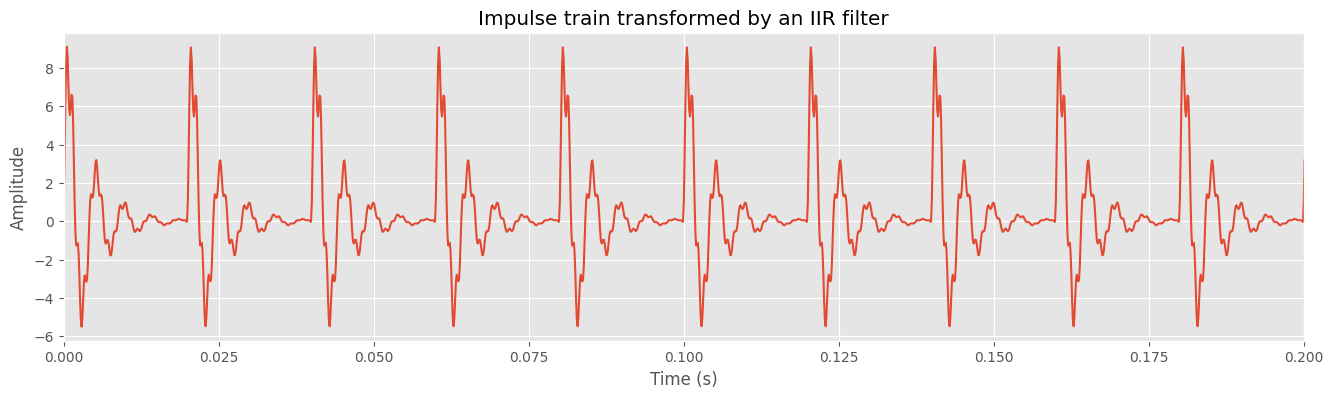

In [29]:
## Plot the filtered output
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(time_steps, y_iir)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Impulse train transformed by an IIR filter")

## Zoom in a bit
ax.set(xlim=[0.0,0.2])
## Starting to look more speech...ish

## Plotting the spectrogram of the filter output

The waveform definitely looks different from an impulse train and perhaps even a bit more speech like. But as we've seen previously, it's very difficult to "see" what a waveform will sound like in the time domain.  Let's plot the spectrograms of impulse train and the filter output to see what happened in the frequency domain. 

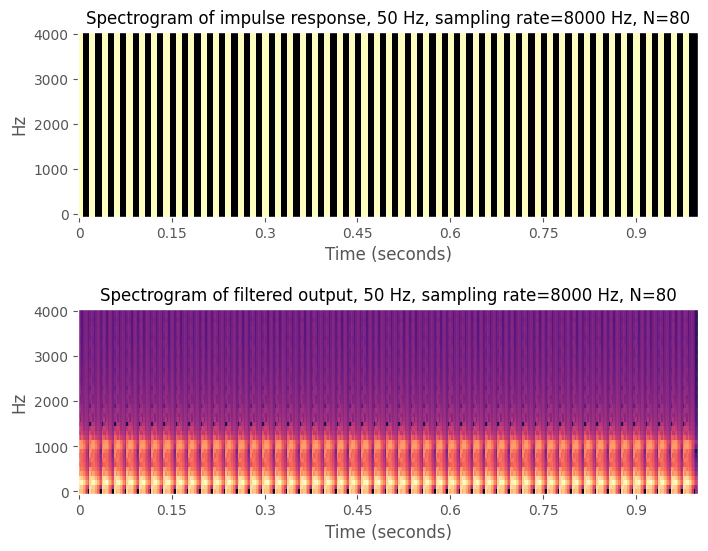

In [30]:
## Since the sampling rate of the impulse train was 8000 Hz
## Let's set the size of the DFT input window to N=80 to make calculating 
## The analysis frequencies easy
N=80

## Get the spectrogram of the impulse train
mags_x_imp = np.abs(librosa.stft(x_imp, n_fft=N, window="boxcar"))

## Get the spectogram of the filter output
mags_y_iir = np.abs(librosa.stft(y_iir, n_fft=N, window="boxcar"))

## Set up two subplots
fig, axs = plt.subplots(2, 1, figsize=(8,6))
plt.subplots_adjust(hspace=0.5)

## Plot the spectrogram of the impulse response
axs[0].set_title(f"Spectrogram of impulse response, {frequency} Hz, sampling rate={f_s} Hz, N={N}", fontsize=12) 
librosa.display.specshow(librosa.amplitude_to_db(mags_x_imp, ref=np.max), sr=f_s, n_fft=N, hop_length=N//4,
                         y_axis='linear', x_axis='s', ax=axs[0])

## Plot the spectrogram of the filter output
axs[1].set_title(f"Spectrogram of filtered output, {frequency} Hz, sampling rate={f_s} Hz, N={N}", fontsize=12) 
librosa.display.specshow(librosa.amplitude_to_db(mags_y_iir, ref=np.max), sr=f_s, n_fft=N, hop_length=N//4,
                         y_axis='linear', x_axis='s', ax=axs[1])



Relative to the spectrogram for the impulse train, the filter output has two very clear formants.  We can see the frequency 
response by looking at the magnitude spectrums of a specific frame (i.e., spectral slices).

**Question:** What do formants tell us about what this specific filter does in source-filter model terms? 

**Task:** Before we plot the spectral slices, sketch (on paper) what you expect the spectral envelopes of the impulse train and the filtered impulse train to look like based on the spectrogram. 


It filters amplifies sounds around 100 and 1000 Hz and dampens others.

### Plot the magnitude spectrum

Now let's plot the frequency spectrum (i.e. the magnitude spectrum) for a specific frame in the impulse train and the filtered output. 

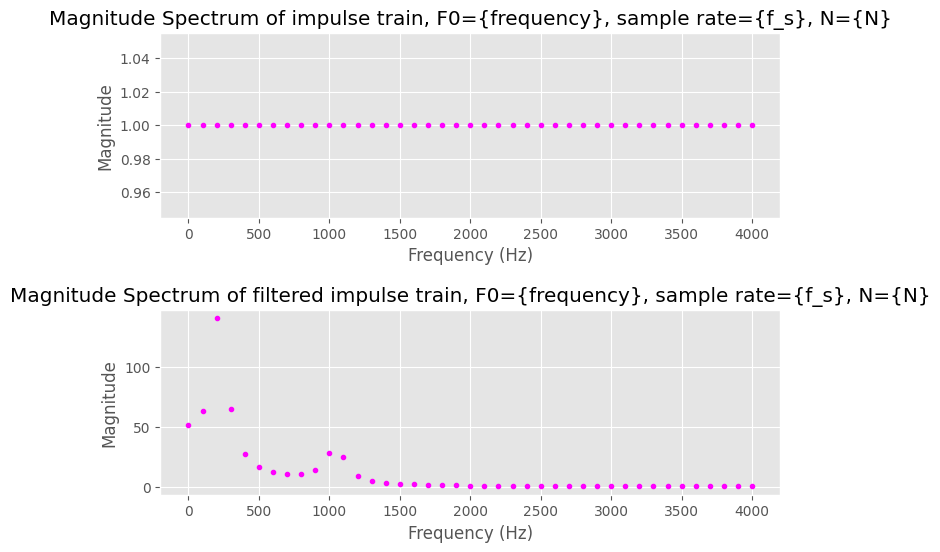

In [31]:
## Set up 2 subplots, one for the mag spectrum of the impulse train and one for the filtered output
fig, axs = plt.subplots(2, 1, figsize=(8,6))

## Put a bit of vertical space between the plots for better viewing
plt.subplots_adjust(hspace=0.5)

## Calculate the analysis frequencies for the x-axis
analysis_freqs = np.arange(0,len(mags_x_imp)) * (f_s/N)

## Plot the magnitude spectrum of the x_imp for frame 50, the impulse train, in the top subplot
axs[0].set_title("Magnitude Spectrum of impulse train, F0={frequency}, sample rate={f_s}, N={N}")
axs[0].set(xlabel="Frequency (Hz)", ylabel="Magnitude")
axs[0].plot(analysis_freqs, mags_x_imp[:,50], linewidth=0, color='magenta', marker=".", label='magnitude')

## Plot the magnitude spectrum of y_iir for frame 50, the filtered output, in the bottom subplot
axs[1].set_title("Magnitude Spectrum of filtered impulse train, F0={frequency}, sample rate={f_s}, N={N}")
axs[1].set(xlabel="Frequency (Hz)", ylabel="Magnitude")
axs[1].plot(analysis_freqs, mags_y_iir[:,50], linewidth=0, color='magenta', marker=".", label='magnitude')





You should see that in the frequency (magnitude) spectrum of the impulse train, all analysis frequencies have magnitude 1, i.e., a flat spectral envelope.  In contrast, the magnitude spectrum of the filtered impulse train has peaks around 250 Hz and 1000 Hz. 
The IIR filter has shaped the spectral envelope of the impulse train.

**Question:** How will the spectrum change if when you change the impulse train frequency to 200Hz? How about 50 Hz? How do the spectrograms change? Change the code above to verify this. 



**Answer**: The general spectral envelope wont change, but we will change the harmonics. For 200 Hz well get gaps, for 50 Hz well not see visible change on the magnitude spectrum.

# Synthesizing speech(-like) sounds

The filter above produce something that looked a bit like formants, but can we get filter coefficients that make more speech-like sounds? 

It turns out that we can derive filter coefficients from our own speech using _Linear Prediction_ analysis.  We won't go into the details of how this works in this course.  Instead we'll use [the librosa function that extracts Linear Prediction Coefficients (LPC)](https://librosa.org/doc/0.10.1/generated/librosa.lpc.html#librosa.lpc). This will give us the coefficients for an IIR filter.

The following code uses recordings of vowels that I recorded and annotated in Praat ('vowels.wav' and 'vowels.TextGrid' in this directory). You should feel free to substitute your own! 


In [32]:
## load the vowel audio file
vowels, sr = librosa.load('vowels.wav')

## Make an audio widget to play the vowels
display(Audio(vowels, rate=sr))

## Read a textgrid into python

We can use the python package praatio to read in the textgrid and get individual tiers. 


In [82]:
## First install praatio
# !pip install praatio

In [33]:
## import the textgrid class from praatio
from praatio import textgrid

## read in the textgrid using the function textgrid.openTextgrid from praatio
tg = textgrid.openTextgrid("vowels.TextGrid", includeEmptyIntervals=False) 

## Get the "phones" tier uing the getTier function
phones = tg.getTier("phones")

## print out the entries in this tier
for i, (start, end, label) in enumerate(phones.entries):
    print(f"{i} label: {label}, start:{start:.2f}, end:{end:.2f}")


0 label: AA-ɑ, start:0.56, end:1.38
1 label: IY-i, start:1.47, end:2.25
2 label: UW-u, start:2.48, end:3.15
3 label: EH-ɛ, start:3.37, end:3.99
4 label: AO-ɔ, start:4.38, end:5.17


So, this tier includes a list of intervals, each with a label, a start time, and an end time. 

The phone labels were annotated to be the [ARPABET](https://en.wikipedia.org/wiki/ARPABET) transcriptions and the corresponding [IPA symbol](https://www.seeingspeech.ac.uk/ipa-charts/?chart=4). ARPABET is very common in speech technology work since it's a bit easier to type later as it just uses standard ascii characters, but it's easy enough to copy and paste the IPA symbols too nowadays.

## Play a vowel interval

You can verify this table is correct by opening up the files in praat. But you can also try playing the part of the audio corresponding to each phone segment in python. 

To do this we need to figure out the start and end times in terms of samples rather than seconds. We can do this by multiplying the time by the sampling rate (`phones['start'] * sr`) and rounding to get to the nearest whole number. 

Let's try it first for the first interval in the tier, corresponding to the ɑ vowel (AA in ARPABET):

In [34]:
## Get the row corresponding to the AA vowel
phone_interval = phones.entries[0]
print(phone_interval)

## calculate the start time in samples
sample_start = round(phone_interval.start * sr)
sample_end = round(phone_interval.end * sr)

## get the part of the waveform corresponding to these samples
x_interval = vowels[sample_start:sample_end]

print(f"\nAudio for {phone_interval.label}")
Audio(x_interval, rate=sr)

Interval(start=0.5598722588446778, end=1.3849471666157822, label='AA-ɑ')

Audio for AA-ɑ


## Plot the spectrogram and mag spectrum

Now let's plot the spectrogram for this interval.

Text(0.5, 1.0, 'Magnitude spectrum (frame 20): AA-ɑ')

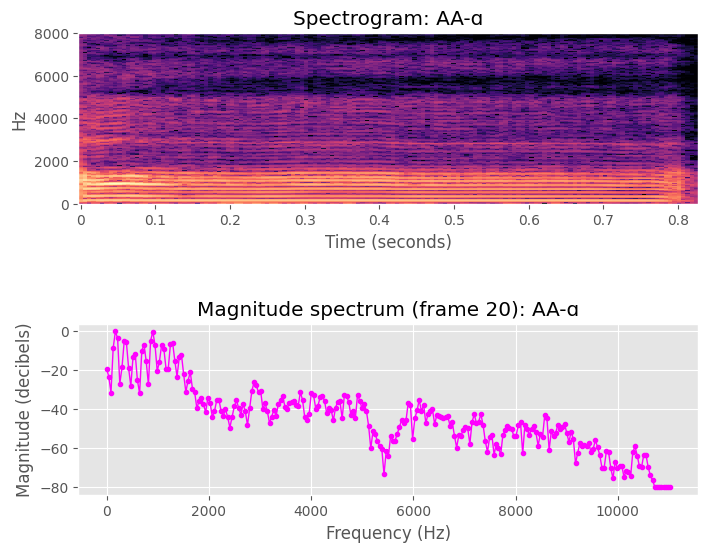

In [37]:
## Get the mag spectrum using an input window of 512 samples
N=512
mags = np.abs(librosa.stft(x_interval, n_fft=N, window="hann"))

## Plot the spectrogram, and a spectral slice
fig, axs = plt.subplots(2, 1, figsize=(8,6))
plt.subplots_adjust(hspace=0.7)


## Spectrogram plot in the top plot
librosa.display.specshow(librosa.amplitude_to_db(mags, ref=np.max), sr=sr, n_fft=N, hop_length=N//4, 
                         y_axis='linear', x_axis='s', ax=axs[0])

## Zoom into 0-8000Hz on the spectrogram
axs[0].set(ylim=[0,8000])
axs[0].set_title(f"Spectrogram: {phone_interval.label}")

## calculate the analysis frequencies
analysis_freqs = np.arange(0,len(mags)) * (sr/N)

## Plot a spectral slice at frame 20, magnitudes converted to in decibels to match the spectrogram
axs[1].plot(analysis_freqs, librosa.amplitude_to_db(mags[:,20], ref=np.max), linewidth=1, color='magenta', marker=".", label='magnitude')
axs[1].set(xlabel="Frequency (Hz)", ylabel="Magnitude (decibels)")
axs[1].set_title(f"Magnitude spectrum (frame 20): {phone_interval.label}")


You should see the spectrogram for the AA vowel has it's first two formants squished together beloow 2000 Hz, which is what we'd expect. Remember:

* The first formant, F1 = 300 Hz, corresponds to tongue height 
    * $\rightarrow$ Low F1 means high tongue height 
* The first formant, F2 = 1100 Hz, corresponds to vowel frontness or backness
    * $\rightarrow$ High F2 means tongue positioned to the front 

## Get the Filter Coefficients with LPC
Now let's apply the LPC function from librosa to derive IIR filter coefficients from our AA segment.  

In [38]:
## apply the an order 10 lpc analysis function from librosa
lpc_coeffs = librosa.lpc(x_interval, order=10)

## Let's see what they are!
lpc_coeffs

array([ 1.        , -2.5456533 ,  2.9824681 , -2.8151364 ,  2.588271  ,
       -2.2561758 ,  1.9693917 , -1.4659477 ,  1.0419877 , -0.6774814 ,
        0.19994429], dtype=float32)

This gives us back an array of numbers, but what do they mean? 
LPC learns a specific type of filter of the form:

$$ y[n] = x[n] + \sum_{k=1}^M a[k] y[n-k]$$

which is equivalent to the computational form of the source filter model given [in the videos](https://speech.zone/courses/speech-processing/module-4-the-source-filter-model/videos-3/source-filter-model/) (just with different variable names) 

$$ s[t] = e[t] + \sum_{k=1}^M a[k] s[t-k]$$

The main thing to note is that LPC only "learns" the $a[k]$ terms, i.e., the coefficients that weight the previous _outputs_ of the filter itself.  It turns out that these $a[k]$ terms determine where peaks will occur in the filter frequency responses (you might see these referred to as 'poles' in signal processing terms).  That is, the position of the resonances/formants.  

In fact, LPC is the main part of what is used to automatically find formant values in Praat! If you've played around with that before, you'll know that you need to tell it how many formants (i.e. peaks) you want to find.  This corresponds to the "order" parameter in the LPC function above.  In general, you need 2 coefficients per peak.  So, to determine 5 formants, we need an order 10 filter.  

Now we get 11 numbers out of the librosa LPC function.  These represent 
$a[0]=1$ (which we'll discard) and then the 10 coefficients of $y[n-1],..y[n-10]$ we'll use to model the actual vocal tract filter (i.e., the $a[k]$ values).  The term we discard is there  because what LPC estimates an equivalent but slightly different form of the filter. Because of this we will also need to multiply the coefficients by -1 in our IIR function. This is beyond the scope of this course but you can find more details on this in, for example, [Taylor's Speech Synthesis textbook (Chapter 12)](https://speech.zone/readings/taylor-text-to-speech-synthesis/chapter-12-analysis-of-speech-signals/taylor-section-12-4-linear-prediction-analysis/)



## Apply the filter to an impulse train

As before, we can now apply the filter to an impulse train to generate a sound. 

### Create an impulse train

In [39]:
## Set the sampling rate to the same as the recording, 22050
f_s = sr

## Generate 1 second of sound
N = f_s 

## Set the impulse train frequency to 200 Hz
frequency = 200

## Generate N samples of an impulse train with frequency=frequency given a sampling rate of f_s
x_imp, time_steps = get_impulse_train(sample_rate=f_s, frequency=frequency, n_samples=N)

display(Audio(x_imp, rate=f_s))


impulse_positions: [    0   110   220   330   440   550   660   770   880   990  1100  1210
  1320  1430  1540  1650  1760  1870  1980  2090  2200  2310  2420  2530
  2640  2750  2860  2970  3080  3190  3300  3410  3520  3630  3740  3850
  3960  4070  4180  4290  4400  4510  4620  4730  4840  4950  5060  5170
  5280  5390  5500  5610  5720  5830  5940  6050  6160  6270  6380  6490
  6600  6710  6820  6930  7040  7150  7260  7370  7480  7590  7700  7810
  7920  8030  8140  8250  8360  8470  8580  8690  8800  8910  9020  9130
  9240  9350  9460  9570  9680  9790  9900 10010 10120 10230 10340 10450
 10560 10670 10780 10890 11000 11110 11220 11330 11440 11550 11660 11770
 11880 11990 12100 12210 12320 12430 12540 12650 12760 12870 12980 13090
 13200 13310 13420 13530 13640 13750 13860 13970 14080 14190 14300 14410
 14520 14630 14740 14850 14960 15070 15180 15290 15400 15510 15620 15730
 15840 15950 16060 16170 16280 16390 16500 16610 16720 16830 16940 17050
 17160 17270 17380 17490 17600 1

### Apply the filter

To use the `iir_filter` function we used earlier, we'll need separate  $a$ and $b$ coefficients.  The $b$ coefficient is just $1$.  The $a$ values are actually $-1$ times the output, skipping the first coefficient returned by LPC (again this may seem a bit arbitrary, but it's because of the differences in form between what LPC returns and the way we are applying the filter in the time domain mentioned above).  


In [40]:
## set the b coefficient (applies to input waveform)
b = [1]

## set the a coefficient (applies to previous filter outputs)
## these are the lpc outputs, discarding the very first one
a =  -1*lpc_coeffs[1:]

## Apply the IIR filter to the impulse train
y_iir = iir_filter(x_imp, a=a, b=b)

display(Audio(y_iir, rate=f_s))

Well, that sounds a bit more "ah"-ish, but still not very human like! How about the other vowels? Let's try the next one in the recording which was the "IY-i".


In [41]:
## Get the row corresponding to a specific vowel
phone_interval = phones.entries[1]

## calculate the start time in samples
sample_start = round(phone_interval.start * sr)
sample_end = round(phone_interval.end * sr)

x_interval = vowels[sample_start:sample_end]

print(f"\nAudio for {phone_interval.label}")
display(Audio(x_interval, rate=sr))

## Get the LPC outputs, start with order 10
lpc_coeffs = librosa.lpc(x_interval, order=10)

## set the b coefficient (applies to input waveform)
b = [1]

## set the a coefficient (applies to previous filter outputs)
## these are the lpc outputs, discarding the very first one
a =  -1*lpc_coeffs[1:]

## Apply the IIR filter to the impulse train
y_iir = iir_filter(x_imp, a=a, b=b)

print("synthesized vowel")
display(Audio(y_iir, rate=f_s))

print("impulse train")
display(Audio(x_imp, rate=f_s))


Audio for IY-i


synthesized vowel


impulse train


You should be able to hear that we're (sort of!) capturing different vowel qualities,  it's a lot easier to distinguish the synthesized sounds in contrast to each other. 

Let's write a function to generate the different synthesize vowels and listen to them all in turn. 



In [43]:
## Get the waveform for the target phone interval
def get_phone_wav(phone_interval, input_audio):
    ## calculate the start time in samples  
    sample_start = round(phone_interval.start * sr)
    sample_end = round(phone_interval.end * sr)

    ## Get the bit of the input audio that corresponds to those samples
    x_interval = input_audio[sample_start:sample_end]

    ## Retrun the audio interval, and also the phone label (for convenience)
    return x_interval, phone_interval.label

## Apply LPC to the audio in wav and return the coefficients for the IIR filter in the form we want 
def get_iir_filter_coeffs(wav, lpc_order=10):
    ## Get the LPC outputs given the audio in x_interval
    lpc_coeffs = librosa.lpc(wav, order=lpc_order)

    ## set the b coefficient (applies to input waveform)
    b = [1]

    ## set the a coefficient (applies to previous filter outputs)
    ## these are the lpc outputs, discarding the very first one
    a =  -1*lpc_coeffs[1:]

    return a, b





Now run a loop over the phone intervals and synthesize audio from the extracted LPC values for each vowel

In [58]:
## make a dictionary to store the output wavs
output_wavs = {}

## Set the order of the LPC filter
lpc_order = 10

## Set the frequency of the impulse train
frequency=250

## Set the sample rate for the impulse train
sample_rate=sr

## Set the number of samples to generate 
## Set to sr to generate 1 second
N=sr

for phone_interval in  phones.entries:
    curr_wav, label = get_phone_wav(phone_interval, vowels)
    #print(f"\nAudio for {label}")
    #display(Audio(curr_wav, rate=sr))

    ## Get LPC based IIR filter coefficients from wav
    a, b  = get_iir_filter_coeffs(curr_wav, lpc_order=lpc_order)
    
    ## Generate N samples of an impulse train with frequency=frequency given a sampling rate of f_s
    x_imp, time_steps =  get_impulse_train(sample_rate=sample_rate, frequency=frequency, n_samples=N)
       
    ## Apply the IIR filter to the impulse train
    y_iir = iir_filter(x_imp, a=a, b=b)
        
    print(f"\nsynthesized {label}")
    display(Audio(y_iir, rate=sr))

    ## Store the filter output in a dictionary where we refer to the 
    ## wav by the ARPABET phone, i.e., first 2 letters in the label
    output_wavs[label[0:2]] = y_iir



impulse_positions: [    0    88   176   264   352   440   528   616   704   792   880   968
  1056  1144  1232  1320  1408  1496  1584  1672  1760  1848  1936  2024
  2112  2200  2288  2376  2464  2552  2640  2728  2816  2904  2992  3080
  3168  3256  3344  3432  3520  3608  3696  3784  3872  3960  4048  4136
  4224  4312  4400  4488  4576  4664  4752  4840  4928  5016  5104  5192
  5280  5368  5456  5544  5632  5720  5808  5896  5984  6072  6160  6248
  6336  6424  6512  6600  6688  6776  6864  6952  7040  7128  7216  7304
  7392  7480  7568  7656  7744  7832  7920  8008  8096  8184  8272  8360
  8448  8536  8624  8712  8800  8888  8976  9064  9152  9240  9328  9416
  9504  9592  9680  9768  9856  9944 10032 10120 10208 10296 10384 10472
 10560 10648 10736 10824 10912 11000 11088 11176 11264 11352 11440 11528
 11616 11704 11792 11880 11968 12056 12144 12232 12320 12408 12496 12584
 12672 12760 12848 12936 13024 13112 13200 13288 13376 13464 13552 13640
 13728 13816 13904 13992 14080 1

impulse_positions: [    0    88   176   264   352   440   528   616   704   792   880   968
  1056  1144  1232  1320  1408  1496  1584  1672  1760  1848  1936  2024
  2112  2200  2288  2376  2464  2552  2640  2728  2816  2904  2992  3080
  3168  3256  3344  3432  3520  3608  3696  3784  3872  3960  4048  4136
  4224  4312  4400  4488  4576  4664  4752  4840  4928  5016  5104  5192
  5280  5368  5456  5544  5632  5720  5808  5896  5984  6072  6160  6248
  6336  6424  6512  6600  6688  6776  6864  6952  7040  7128  7216  7304
  7392  7480  7568  7656  7744  7832  7920  8008  8096  8184  8272  8360
  8448  8536  8624  8712  8800  8888  8976  9064  9152  9240  9328  9416
  9504  9592  9680  9768  9856  9944 10032 10120 10208 10296 10384 10472
 10560 10648 10736 10824 10912 11000 11088 11176 11264 11352 11440 11528
 11616 11704 11792 11880 11968 12056 12144 12232 12320 12408 12496 12584
 12672 12760 12848 12936 13024 13112 13200 13288 13376 13464 13552 13640
 13728 13816 13904 13992 14080 1

impulse_positions: [    0    88   176   264   352   440   528   616   704   792   880   968
  1056  1144  1232  1320  1408  1496  1584  1672  1760  1848  1936  2024
  2112  2200  2288  2376  2464  2552  2640  2728  2816  2904  2992  3080
  3168  3256  3344  3432  3520  3608  3696  3784  3872  3960  4048  4136
  4224  4312  4400  4488  4576  4664  4752  4840  4928  5016  5104  5192
  5280  5368  5456  5544  5632  5720  5808  5896  5984  6072  6160  6248
  6336  6424  6512  6600  6688  6776  6864  6952  7040  7128  7216  7304
  7392  7480  7568  7656  7744  7832  7920  8008  8096  8184  8272  8360
  8448  8536  8624  8712  8800  8888  8976  9064  9152  9240  9328  9416
  9504  9592  9680  9768  9856  9944 10032 10120 10208 10296 10384 10472
 10560 10648 10736 10824 10912 11000 11088 11176 11264 11352 11440 11528
 11616 11704 11792 11880 11968 12056 12144 12232 12320 12408 12496 12584
 12672 12760 12848 12936 13024 13112 13200 13288 13376 13464 13552 13640
 13728 13816 13904 13992 14080 1

impulse_positions: [    0    88   176   264   352   440   528   616   704   792   880   968
  1056  1144  1232  1320  1408  1496  1584  1672  1760  1848  1936  2024
  2112  2200  2288  2376  2464  2552  2640  2728  2816  2904  2992  3080
  3168  3256  3344  3432  3520  3608  3696  3784  3872  3960  4048  4136
  4224  4312  4400  4488  4576  4664  4752  4840  4928  5016  5104  5192
  5280  5368  5456  5544  5632  5720  5808  5896  5984  6072  6160  6248
  6336  6424  6512  6600  6688  6776  6864  6952  7040  7128  7216  7304
  7392  7480  7568  7656  7744  7832  7920  8008  8096  8184  8272  8360
  8448  8536  8624  8712  8800  8888  8976  9064  9152  9240  9328  9416
  9504  9592  9680  9768  9856  9944 10032 10120 10208 10296 10384 10472
 10560 10648 10736 10824 10912 11000 11088 11176 11264 11352 11440 11528
 11616 11704 11792 11880 11968 12056 12144 12232 12320 12408 12496 12584
 12672 12760 12848 12936 13024 13112 13200 13288 13376 13464 13552 13640
 13728 13816 13904 13992 14080 1

impulse_positions: [    0    88   176   264   352   440   528   616   704   792   880   968
  1056  1144  1232  1320  1408  1496  1584  1672  1760  1848  1936  2024
  2112  2200  2288  2376  2464  2552  2640  2728  2816  2904  2992  3080
  3168  3256  3344  3432  3520  3608  3696  3784  3872  3960  4048  4136
  4224  4312  4400  4488  4576  4664  4752  4840  4928  5016  5104  5192
  5280  5368  5456  5544  5632  5720  5808  5896  5984  6072  6160  6248
  6336  6424  6512  6600  6688  6776  6864  6952  7040  7128  7216  7304
  7392  7480  7568  7656  7744  7832  7920  8008  8096  8184  8272  8360
  8448  8536  8624  8712  8800  8888  8976  9064  9152  9240  9328  9416
  9504  9592  9680  9768  9856  9944 10032 10120 10208 10296 10384 10472
 10560 10648 10736 10824 10912 11000 11088 11176 11264 11352 11440 11528
 11616 11704 11792 11880 11968 12056 12144 12232 12320 12408 12496 12584
 12672 12760 12848 12936 13024 13112 13200 13288 13376 13464 13552 13640
 13728 13816 13904 13992 14080 1

You can probably recognize these as vowels and distinguish them from one another, but again it's still fairly far from human.  This should give you an idea of some of the difficulties in this approach to synthesis: there's a lot more to human speech than just getting the formants in the right place! 

**Task:** Try varying the F0 of the impulse train and the order of the LPC analysis and see what happens to our synthesize vowels.  

**Question:** If we wanted to vary the F0 to produce more human like pitch changes, what would we have to do?  Would change be on the filter or the impulse train? 

**Task:** Increase `lpc_order` to 20. 

**Question:**  What affect does increasing the filter order have?  Does the vowel quality change? How about if you increase it to 30?

**Question:** You can basically capture 1 peak for every 2 LPC coefficients. Can you distinguish the vowels when the LPC order is set to 2? Should you be able to?

Q1: To change the pitch we woulc change the impulse train. 

Q2: Increasing filter order seems to make the vowel more human (also increases processing time).

Q3: We are just about able to distinguish the vowels, as we pick up F1 using our filter. However, we only have vowels that vary quite significantly in height, telling a and o apart was more challenging. This makes sense as qw will only pick up F1.

### Spectral envelopes of synthesized vowels

You can use the following code to look at the frequency spectrums of the synthesized vowels.

**Question:** Are the formant patterns what you'd expect based on our knowledge of the relationship between F1 and F2 and the "English" vowel space?  What happens if you change the LPC filter order?

[Text(0.5, 0, 'Frequency (Hz)'), Text(0, 0.5, 'Magnitude (dB)')]

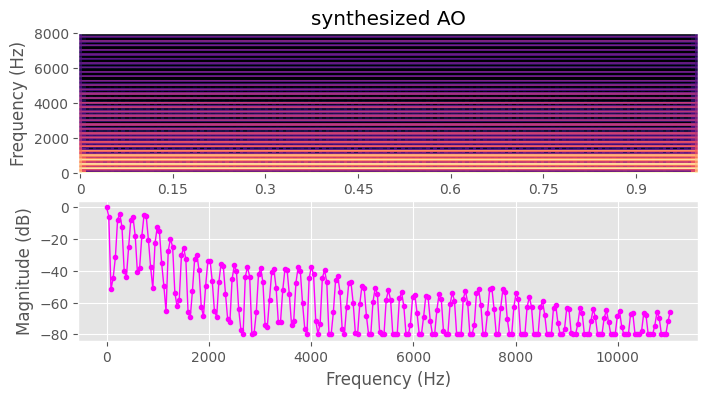

In [59]:
## Get the spectrogram
N=512
label="AO"
mags = np.abs(librosa.stft(output_wavs[label], n_fft=N, window="hann"))

## Plot the spectrogram and the mag spectrum/spectral slice at a specific frame
fig, axs = plt.subplots(2, 1, figsize=(8,4))

## Plot the spectrogram
librosa.display.specshow(librosa.amplitude_to_db(mags, ref=np.max), sr=f_s, n_fft=N, hop_length=N//4,
                         y_axis='linear', x_axis='time', ax=axs[0])
axs[0].set(ylim=[0,8000])
axs[0].set(ylabel="Frequency (Hz)", xlabel="Time (s)", title=f"synthesized {label}")

## Plot the mag spectrum in dB
analysis_freqs = np.arange(0,len(mags)) * (sr/N)
axs[1].plot(analysis_freqs, librosa.amplitude_to_db(mags[:,20], ref=np.max), linewidth=1, color='magenta', marker=".", label='magnitude')
axs[1].set(xlabel="Frequency (Hz)", ylabel="Magnitude (dB)")



## Changing the source? 

**Question:** Below is some code for generating some white noise: we randomly select amplitude values based on a normal distribution. What happens if you use this to generate a vowel instead of an impulse train? Can you still hear the vowel? 


In [64]:
## Generate sr samples (i.e., 1 second) of noise by randomly selecting
## values from a "normal" distribution
noise=np.random.normal(0, 0.1, sr)

## Play the noise! 
Audio(noise, rate=22050)


In [65]:
## Let's do this for IY first!  
phone_interval = phones.entries[i]

curr_wav, label = get_phone_wav(phone_interval, vowels)
a, b  = get_iir_filter_coeffs(curr_wav, lpc_order=lpc_order)

y_noise = iir_filter(noise, a=a, b=b)
Audio(y_noise, rate=sr)

# Practice Problems

1. Assume you filter apply a filter to an impulse train with a F0 of 340 Hz.  The frequency spectrum of the resulting filtered waveform shows peaks at 300 Hz and 1600 Hz.  If you applied the same filter to an impulse train with F0 100 Hz, what would change?

3. Assume you want to create sounds that have a 16kHz sampling rate. What would we expect the frequency response (i.e. magnitude spectrum) of a filter that produced at [z] sound to look like? What sort of source would you need to get the effects of both voicing and frication?

4. You've seen above that pre-emphasis filters "boost" higher frequencies in a signal.  Why might this be a useful thing to do with respect to detecting formants in speech? 


### Notes

1. ~~The peaks would be higher, as they would fall on an analysis frequency of the signal.~~ The peaks would be unchanged, but the harmonic structure would. The analysis frequency don't depend on the impulse train but on sampling rate and window size.
2. Quite focused in the higher frequency. As a source you would need a sum of noise and an impulse train.
3. Usually F3 and above appear above the 2 kHz band and are quite faint, so emphasising these frequencies makes them more visible.

# Extensions: 

You can find some more notebooks that look at impulse trains, FIR and IIR filters in the extension material in this repository. 

* [Building the source: impulse trains](./extension/signals-2-ext-1-impulse-as-source.ipynb)
* [Finite Impluse Response filters](./extension/signals-2-ext-2-fir-filters.ipynb)
* [Infinite Impluse Response filters](./extension/signals-2-ext-3-iir-filters.ipynb)
* [The moving average as a rectangular filter](./extension/signals-2-ext-4-rectangular-filters-extension.ipynb)
* [Derivations of example IIR filters](./extension/signals-2-ext-5-iir-filters-derivations.ipynb)

If you're interested in learning more about filters or signal processing in general, it's probably time to pick up a Digital Signal Processing textbook. Rick Lyon's [Understanding Digital Signal Processing](https://www.dsprelated.com/books/6.php) is probably the most accessible I've come across. It's available online from the University of Edinburgh library.  It's not required for this course but it's a good investment if you want to learn more about digital processing in the future. 

Previous SLP students have also recommended [The Scientist and Engineer's Guide to
Digital Signal Processing](http://www.dspguide.com/pdfbook.htm), though the free online version renders a bit weirdly!. 

